In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional
from torch.utils.data import DataLoader
from torchvision import utils
from torchvision.utils import save_image
from torchvision import transforms as T

import config
from dataset import (
    CompressedImageDataset,
    ImageDataset,
    cifar10,
    imagenet_mini,
)
# from model import Classifier, Encoder

from compress import HyperpriorWrapper
from utils import load_checkpoint, norm, save_checkpoint, unnorm, plot

import pickle

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from sklearn.metrics import roc_curve, RocCurveDisplay, accuracy_score, precision_score, roc_auc_score, classification_report

In [4]:
from tqdm.notebook import tqdm

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_WORKERS = 16
NUM_EPOCHS = 100

train_transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize(size=(256, 256)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(30),
        # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

val_transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize(size=(256, 256)),
        # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [6]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, n_features=64):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(in_channels, n_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_features),
            nn.ReLU(),
            nn.Conv2d(n_features, n_features*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_features*2),
            nn.ReLU(),
            nn.Conv2d(n_features*2, n_features*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_features*4),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

    def forward(self, x):
        x = self.enc(x)
        return x #.squeeze()


class Classifier(nn.Module):
    def __init__(
        self,
        in_features=49152,
        n_classes=10,
        dropout=0.2,
        n_hidden=1024,
    ):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, n_hidden),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//2),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(n_hidden//2, n_classes)
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [7]:
print(DEVICE)

# compressor = None
compressor = (
    HyperpriorWrapper(1, pretrained=True)
    .eval()
    .to(DEVICE)
)
# CH = 3 if compressor is None else 192

# model = Classifier(in_features=192*16*16, n_classes=10, hidden_layers=0, n_hidden=1024)
enc = Encoder(in_channels=192, n_features=512).to(DEVICE)
clf = Classifier(in_features=2048, n_hidden=1024).to(DEVICE)

model = nn.Sequential(enc, clf).to(DEVICE)
opt = optim.Adam(
    list(model.parameters()),
    lr=LEARNING_RATE
)



cuda


In [7]:
criterion = nn.CrossEntropyLoss()

In [8]:
dataset_val = ImageDataset(
    root=cifar10.val_root, transform=val_transform
)
dataloader_val = DataLoader(
    dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [9]:
compressor = HyperpriorWrapper(1, pretrained=True).eval().to(DEVICE)

In [10]:
@torch.no_grad()
def compress(x, co):
    # compressed = co.compress(x)
    # return co.entropy_decode(compressed["strings"], compressed["shape"])
    return co.encode(x)


@torch.no_grad()
def decompress(y, co):
    return co.decode(y)
    # compressed = co.entropy_encode(y)
    # return co.decompress(compressed["strings"], compressed["shape"])

In [11]:
# load_checkpoint("checkpoints/clf_cifar10_compress_70.pth", model, opt, LEARNING_RATE)
load_checkpoint("checkpoints/clf_cifar10_256_compress_82.pth", model, opt, LEARNING_RATE)

NameError: name 'model' is not defined

In [ ]:
images, labels = iter(dataloader_val).next()
images = images.to(DEVICE)
compressed = compressor.compress(images)
decoded = compressor.entropy_decode(compressed["strings"], compressed["shape"])
decompressed = compressor.decode(decoded)
out = model(decoded)
pred = out.argmax(dim=-1)
plt.figure(figsize=(10, 10), dpi=96)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = T.ToPILImage()(decompressed[i])
    label_p = dataset_val.labels[pred[i].item()]
    label_t= dataset_val.labels[labels[i].item()]
    plt.imshow(image)
    plt.title(label_t + " / " + label_p)
plt.tight_layout()

In [193]:
decoded.shape

torch.Size([32, 192, 16, 16])

In [194]:
from torchsummary import summary

In [195]:
summary(model[0], (192, 16, 16), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [16, 512, 16, 16]         885,248
       BatchNorm2d-2          [16, 512, 16, 16]           1,024
              ReLU-3          [16, 512, 16, 16]               0
            Conv2d-4         [16, 1024, 16, 16]       4,719,616
       BatchNorm2d-5         [16, 1024, 16, 16]           2,048
              ReLU-6         [16, 1024, 16, 16]               0
            Conv2d-7         [16, 2048, 16, 16]      18,876,416
       BatchNorm2d-8         [16, 2048, 16, 16]           4,096
              ReLU-9         [16, 2048, 16, 16]               0
AdaptiveAvgPool2d-10           [16, 2048, 1, 1]               0
Total params: 24,488,448
Trainable params: 24,488,448
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 336.25
Params size (MB): 93.42
Es

In [25]:
summary(model[1], (2048, 1, 1), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [16, 2048]               0
            Linear-2                 [16, 1024]       2,098,176
           Dropout-3                 [16, 1024]               0
              ReLU-4                 [16, 1024]               0
            Linear-5                  [16, 512]         524,800
           Dropout-6                  [16, 512]               0
              ReLU-7                  [16, 512]               0
            Linear-8                   [16, 10]           5,130
Total params: 2,628,106
Trainable params: 2,628,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.81
Params size (MB): 10.03
Estimated Total Size (MB): 10.96
----------------------------------------------------------------


In [27]:
summary(compressor.model, (3, 256, 256), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [16, 128, 128, 128]           9,728
        LowerBound-2                       [16]               0
NonNegativeParametrizer-3                       [16]               0
        LowerBound-4                  [16, 128]               0
NonNegativeParametrizer-5                  [16, 128]               0
               GDN-6        [16, 128, 128, 128]               0
            Conv2d-7          [16, 128, 64, 64]         409,728
        LowerBound-8                       [16]               0
NonNegativeParametrizer-9                       [16]               0
       LowerBound-10                  [16, 128]               0
NonNegativeParametrizer-11                  [16, 128]               0
              GDN-12          [16, 128, 64, 64]               0
           Conv2d-13          [16, 128, 32, 32]         409,728
       LowerBound-

In [31]:
from torchvision.models import vgg19
summary(vgg19(pretrained=True), (3, 256, 256), batch_size=16, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 256, 256]           1,792
              ReLU-2         [16, 64, 256, 256]               0
            Conv2d-3         [16, 64, 256, 256]          36,928
              ReLU-4         [16, 64, 256, 256]               0
         MaxPool2d-5         [16, 64, 128, 128]               0
            Conv2d-6        [16, 128, 128, 128]          73,856
              ReLU-7        [16, 128, 128, 128]               0
            Conv2d-8        [16, 128, 128, 128]         147,584
              ReLU-9        [16, 128, 128, 128]               0
        MaxPool2d-10          [16, 128, 64, 64]               0
           Conv2d-11          [16, 256, 64, 64]         295,168
             ReLU-12          [16, 256, 64, 64]               0
           Conv2d-13          [16, 256, 64, 64]         590,080
             ReLU-14          [16, 256,

In [11]:
from torchvision.models import vgg19
vgg = vgg19(pretrained=True)
# for param in vgg.parameters():
#     param.requires_grad = False
in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(in_features, 10)
vgg = vgg.to(DEVICE)
opt = optim.Adam(
    list(vgg.parameters()),
    lr=LEARNING_RATE
)
load_checkpoint("checkpoints/vgg_92.pth", vgg, opt, LEARNING_RATE)

=> Loading checkpoint


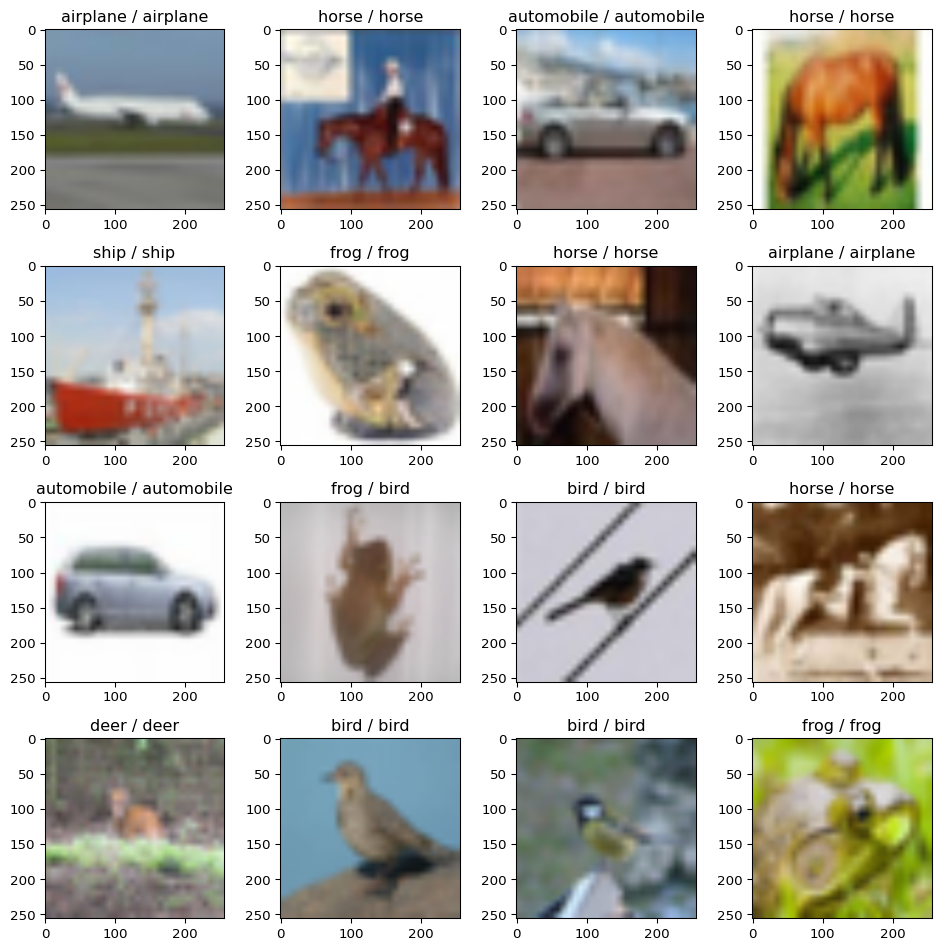

In [12]:
images, labels = iter(dataloader_val).next()
images = images.to(DEVICE)
# compressed = compressor.compress(images)
# decoded = compressor.entropy_decode(compressed["strings"], compressed["shape"])
# decompressed = compressor.decode(decoded)
out = vgg(images)
pred = out.argmax(dim=-1)
plt.figure(figsize=(10, 10), dpi=96)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = T.ToPILImage()(images[i])
    label_p = dataset_val.labels[pred[i].item()]
    label_t= dataset_val.labels[labels[i].item()]
    plt.imshow(image)
    plt.title(label_t + " / " + label_p)
plt.tight_layout()

In [10]:
def predict(model, dataloader, co=True):
    ys = []
    preds = []
    logits = []
    losses = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(dataloader_val):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            if co:
                x = compress(x, compressor)
            out = model(x)
            loss = criterion(out, y)

            losses.append(loss.item())
            ys.extend(y.cpu().numpy())
            preds.extend(out.argmax(dim=-1).cpu().numpy())
            logits.extend(F.softmax(out, dim=1).cpu().numpy())
    return ys, preds, logits, losses

In [215]:
ys, preds, logits, losses = predict(model, dataloader_val)

  0%|          | 0/313 [00:00<?, ?it/s]

In [216]:
accuracy_score(ys, preds)

0.8254

In [217]:
precision_score(ys, preds, labels=list(range(10)), average=None, zero_division=0)

array([0.94557823, 0.77005871, 0.81034483, 0.76529338, 0.85064935,
       0.87400794, 0.93118757, 0.79719703, 0.73730862, 0.81567329])

In [218]:
roc_auc_score(ys, logits, labels=list(range(10)), multi_class="ovr")

0.9848580666666666

In [219]:
print(classification_report(ys, preds, labels=list(range(10)), target_names=dataset_val.labels, zero_division=0))

              precision    recall  f1-score   support

        ship       0.95      0.83      0.89      1000
         dog       0.77      0.79      0.78      1000
       horse       0.81      0.89      0.85      1000
         cat       0.77      0.61      0.68      1000
        deer       0.85      0.79      0.82      1000
        frog       0.87      0.88      0.88      1000
       truck       0.93      0.84      0.88      1000
  automobile       0.80      0.97      0.87      1000
    airplane       0.74      0.92      0.82      1000
        bird       0.82      0.74      0.78      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.82     10000
weighted avg       0.83      0.83      0.82     10000



In [220]:
import pandas as pd

In [221]:
import seaborn as sns

In [222]:
metrics = pd.DataFrame(classification_report(ys, preds, labels=list(range(10)), target_names=dataset_val.labels, zero_division=0, output_dict=True))
metrics.loc["classes"] = metrics.columns
metrics = metrics.transpose()

In [223]:
metrics

,precision,recall,f1-score,support,classes
ship,0.945578,0.834,0.886291,1000.0,ship
dog,0.770059,0.787,0.778437,1000.0,dog
horse,0.810345,0.893,0.849667,1000.0,horse
cat,0.765293,0.613,0.680733,1000.0,cat
deer,0.850649,0.786,0.817048,1000.0,deer
frog,0.874008,0.881,0.87749,1000.0,frog
truck,0.931188,0.839,0.882693,1000.0,truck
automobile,0.797197,0.967,0.873927,1000.0,automobile
airplane,0.737309,0.915,0.8166,1000.0,airplane
bird,0.815673,0.739,0.775446,1000.0,bird


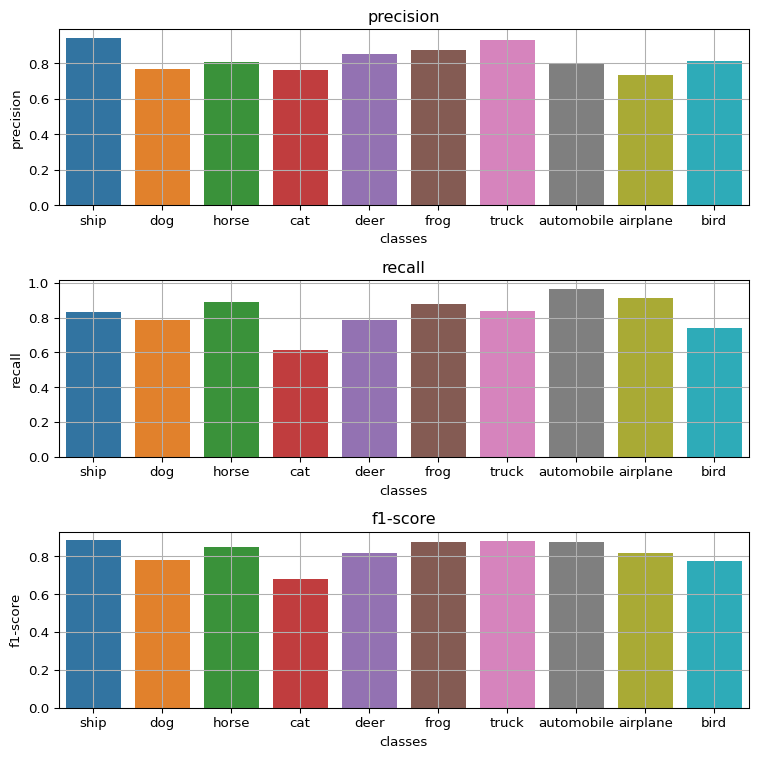

In [224]:
plt.figure(figsize=(8, 8), dpi=96)
plt.subplot(3, 1, 1)
sns.barplot(data=metrics.loc[dataset_val.labels], x="classes", y="precision")
plt.title("precision")
plt.grid()
plt.subplot(3, 1, 2)
sns.barplot(data=metrics.loc[dataset_val.labels], x="classes", y="recall")
plt.title("recall")
plt.grid()
plt.subplot(3, 1, 3)
sns.barplot(data=metrics.loc[dataset_val.labels], x="classes", y="f1-score")
plt.title("f1-score")
plt.tight_layout()
plt.grid()
plt.show()

In [15]:
ys_vgg, preds_vgg, logits_vgg, losses_vgg = predict(vgg, dataloader_val, False)

  0%|          | 0/313 [00:00<?, ?it/s]

In [21]:
import pandas as pd
import seaborn as sns

In [22]:
metrics_vgg = pd.DataFrame(classification_report(ys_vgg, preds_vgg, labels=list(range(10)), target_names=dataset_val.labels, zero_division=0, output_dict=True))
metrics_vgg.loc["classes"] = metrics_vgg.columns
metrics_vgg = metrics_vgg.transpose()

In [23]:
metrics_vgg

,precision,recall,f1-score,support,classes
ship,0.969262,0.946,0.95749,1000.0,ship
dog,0.877878,0.877,0.877439,1000.0,dog
horse,0.955208,0.917,0.935714,1000.0,horse
cat,0.869247,0.831,0.849693,1000.0,cat
deer,0.933679,0.901,0.917048,1000.0,deer
frog,0.928023,0.967,0.947111,1000.0,frog
truck,0.95328,0.959,0.956132,1000.0,truck
automobile,0.957299,0.964,0.960638,1000.0,automobile
airplane,0.911623,0.949,0.929936,1000.0,airplane
bird,0.883588,0.926,0.904297,1000.0,bird


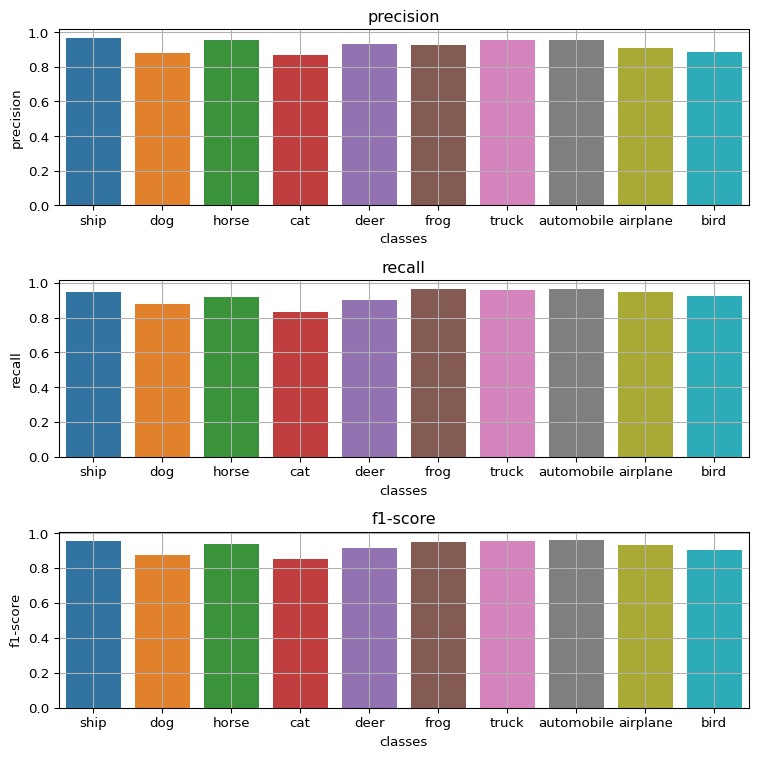

In [24]:
plt.figure(figsize=(8, 8), dpi=96)
plt.subplot(3, 1, 1)
sns.barplot(data=metrics_vgg.loc[dataset_val.labels], x="classes", y="precision")
plt.title("precision")
plt.grid()
plt.subplot(3, 1, 2)
sns.barplot(data=metrics_vgg.loc[dataset_val.labels], x="classes", y="recall")
plt.title("recall")
plt.grid()
plt.subplot(3, 1, 3)
sns.barplot(data=metrics_vgg.loc[dataset_val.labels], x="classes", y="f1-score")
plt.title("f1-score")
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    for x, y in tqdm(dataloader_val):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        if co:
            x = compress(x, compressor)
        out = model(x)

In [91]:
from PIL import Image
from io import BytesIO
import random
import os

'/media/x/dev/compression/classification/dataset/cifar10/test/ship/1407_ship.png'

In [ ]:
img_streams = []
images = []
compressed = []
hidden = []
for _ in tqdm(range(1000)):
    image_path = os.path.join(dataset_val.root, *random.choice(dataset_val.images))
    with open(image_path, "rb") as f:
        image = f.read()
    stream = BytesIO(image)
    img_tensor = val_transform(Image.open(stream)).to(DEVICE)
    compressed_img = compressor.compress(img_tensor[None])
    hidden_tensor = compressor.entropy_decode(comressed_img["strings"], comressed_img["shape"])
    img_streams.append(stream)
    images.append(img_tensor)
    compressed.append(compressed_img)
    hidden.append(hidden_tensor)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [179]:
len(image), len(comressed_img["strings"][0][0]) + len(comressed_img["strings"][1][0])

(2707, 404)

In [169]:
for stream in tqdm(img_streams):
    img = Image.open(stream)
    img_tensor = val_transform(img).to(DEVICE)
    vgg(img_tensor[None])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [170]:
for comressed_img in tqdm(compressed):
    hidden_tensor = compressor.entropy_decode(comressed_img["strings"], comressed_img["shape"])
    model(hidden_tensor)
    # decompressed = compressor.decode(hidden_tensor)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for stream in tqdm(img_streams):
    img = Image.open(stream)
    img_tensor = val_transform(img).to(DEVICE)
    vgg(img_tensor[None])

In [167]:
for hidden_tensor in tqdm(hidden):
    model(hidden_tensor)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [154]:
%%timeit

img = Image.open(stream)
img_tensor = val_transform(img).to(DEVICE)
vgg(img_tensor[None])

10.4 ms ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


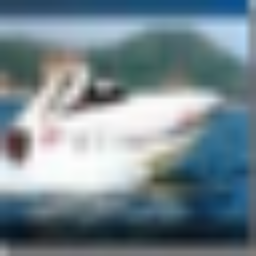

In [101]:
T.ToPILImage()(img_tensor)

In [158]:
compressed = []
for img in tqdm(images):
    img_tensor = val_transform(img).to(DEVICE)
    compressed.append(compressor.compress(img_tensor[None]))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [144]:
%%timeit

hidden_tensor = compressor.entropy_decode(compressed["strings"], compressed["shape"])
model(hidden_tensor)

10.5 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit

hidden_tensor = compressor.entropy_decode(compressed["strings"], compressed["shape"])
model(hidden_tensor)
decompressed = compressor.decode(hidden_tensor)

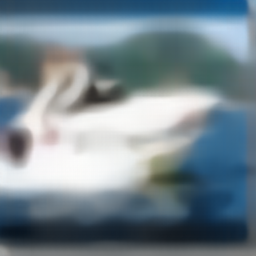

In [138]:
T.ToPILImage()(decompressed.squeeze)